# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.
     - Group Members : Praveen yethapu
                       Akshay jindal

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
#from imageio import imread
from matplotlib.pyplot import imread
from skimage.transform import resize
import datetime
import os
import glob
from skimage import io
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#Reading the CSV file that has the list of all the folders of each gesture.
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 8
#tried multiple values of batch size 32,16 got OutOfmemory for size 32 and is taking almost same time to train for 16 and 8.
# Data size 360X360 and 160X120

In [4]:
#Using only a portion of train and validation for initial Testing the code:
#Disable this total cell in the final RUN:
#val_doc = val_doc[0:8]
#train_doc = train_doc[0:16]
#print(train_doc)

In [5]:
#Defining all the global variables that are required for Images :
image_x = 70
image_y = 70
num_classes = 5
frame_per_video = 10
no_of_channels = 3


### Defining methods for plotting images and grpahs for model accuracy:

In [6]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [7]:
#Function to plot a graph for Accuracy and Loss for each Epoch for a given model and title:
def plot_accuracy_loss_per_epoch(model_history,title = 'Model'):
    # visualise training history
    epochs = [i for i in range(1,len(model_history.history['categorical_accuracy'])+1)]
    plt.figure(figsize=(16,5)) ## setting over-all figure size (optional)
    plt.subplot(1, 2, 1)
    plt.plot(epochs,model_history.history['categorical_accuracy'])
    plt.plot(epochs,model_history.history['val_categorical_accuracy'])
    plt.title("Accuracy For Model - "+title)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc="lower right")
    plt.subplot(1, 2, 2)
    plt.plot(epochs,model_history.history['loss'])
    plt.plot(epochs,model_history.history['val_loss'])
    plt.title("LOSS For Model - "+title)
    plt.ylabel('LOSS')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc="lower right")
    #plt.show();

#### Randomly loading a sample image and performing resizing and normalization

In [8]:
#Loading a random Image frm the input file and frames.
source_path = './Project_data/train'
folder_list = train_doc
t = np.random.permutation(folder_list)
rand_index = rn.randint(0, 8)
folder_path = source_path +"/"+t[rand_index].split(';')[0]+"/*"
images_path = glob.glob(folder_path)
print(images_path[rand_index]) # access an individual file
image = io.imread(images_path[rand_index])
print("Shape of the Image pixels : ",image.shape)


./Project_data/train/WIN_20180925_18_14_35_Pro_Right_Swipe_new/WIN_20180925_18_14_35_Pro_00018.png
Shape of the Image pixels :  (120, 160, 3)


#### (I) Image Normalization Performed :

Plotting the image after doing Normalization and resizing


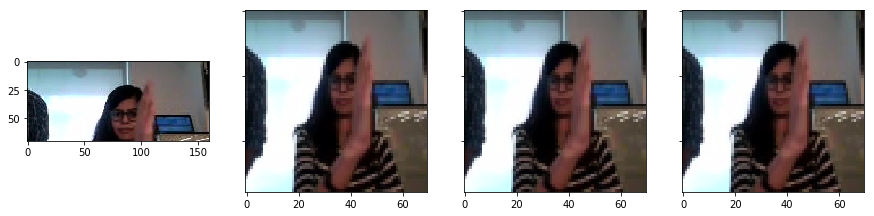

In [9]:
#Image Normalization
import cv2
image_reshape = cv2.resize(image, (image_x,image_y), interpolation = cv2.INTER_AREA)
image_norm1 = np.zeros((image_x,image_y,3))
image_norm2 = np.zeros((image_x,image_y,3))
#simple Normalization:
image_norm1[:,:,0] = image_reshape[:,:,0]/255
image_norm1[:,:,1] = image_reshape[:,:,1]/255
image_norm1[:,:,2] = image_reshape[:,:,2]/255
#Based on MAX MIN normalization:
image_norm2[:,:,0] = (image_reshape[:,:,0] - np.min(image_reshape[:,:,0]))/(np.max(image_reshape[:,:,0]) - np.min(image_reshape[:,:,0]))
image_norm2[:,:,1] = (image_reshape[:,:,1] - np.min(image_reshape[:,:,1]))/(np.max(image_reshape[:,:,1]) - np.min(image_reshape[:,:,1]))
image_norm2[:,:,2] = (image_reshape[:,:,2] - np.min(image_reshape[:,:,2]))/(np.max(image_reshape[:,:,2]) - np.min(image_reshape[:,:,2]))
print("Plotting the image after doing Normalization and resizing")
plot_image([image,image_reshape,image_norm1,image_norm2])

#### (II) Image Augmentation Performed:

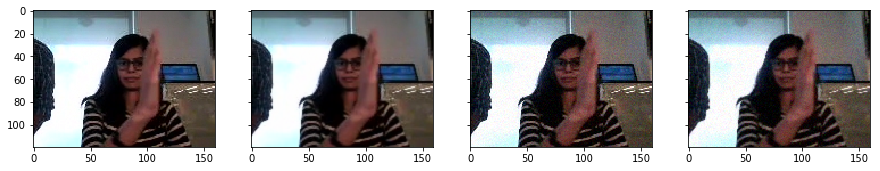

In [10]:
#Data Augmentation used are adding randon noise and blurring the images:
from skimage.util import random_noise
sigma=0.03#blur the image
image_blurred = gaussian(image,sigma=0.5,multichannel=True)
#add random noise to the image
image_noisyRandom = random_noise(image,var=sigma**2)

image_both = random_noise(image_blurred,var=sigma**2)
plot_image([image,image_blurred,image_noisyRandom,image_both])

#### Function to generate img_index given frames per video
- Deleting equal no of frames from the start and from the end

In [11]:
def generate_img_indexes(no_of_frames_per_video):
    #Deleting equal frames from the start and from the end
    if no_of_frames_per_video >= 30 :
        no_of_frames_per_video = 30
    max_frames = 30 
    diff_frames = int((max_frames- no_of_frames_per_video)/2)
    start_frame_no = diff_frames
    end_frame_no = (max_frames - diff_frames)
    img_idx = [i for i in range(start_frame_no,end_frame_no)]
    return img_idx    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [12]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = generate_img_indexes(frame_per_video)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(t)//batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,len(img_idx),image_x,image_y,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    import cv2
                    dimension = (image_x, image_y) 
                    image = cv2.resize(image, dimension, interpolation = cv2.INTER_AREA)
                    
                    #Data Augmentation:
                    #image = gaussian(image,sigma=0.5,multichannel=True)
                    #image = random_noise(image,var=(0.3)**2)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0]) - np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1]) - np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2]) - np.min(image[:,:,2]))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_seq = (len(t)- (batch_size*num_batches))
        if remaining_seq > 0 :
            print("Remaining sequence length is :", remaining_seq)
            batch_data = np.zeros((batch_size,len(img_idx),image_x,image_y,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_seq): # iterate over the remaining folders that are left out after all batches
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    import cv2
                    dimension = (image_x, image_y) 
                    image = cv2.resize(image, dimension, interpolation = cv2.INTER_AREA)
                    
                    #Data Augmentation:
                    #image = gaussian(image,sigma=0.5,multichannel=True)
                    #image = random_noise(image,var=(0.3)**2)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0]) - np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1]) - np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2]) - np.min(image[:,:,2]))

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# No training sequences :', num_train_sequences)
num_val_sequences = len(val_doc)
print('# No validation sequences :', num_val_sequences)
print('# Input Dimensions  : (%s , %s)' %(image_x , image_x))
print('# No of Output Classes : ',num_classes)


# No training sequences : 663
# No validation sequences : 100
# Input Dimensions  : (70 , 70)
# No of Output Classes :  5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### 1. CNN Model with 3D Convolution 

In [14]:
#Global Variables that are required for the Model :
cnn_dropout_rate = 0.2
dense_dropout_rate = 0.5
learning_rate = 0.001
batch_size = 20
num_epochs = 30

image_x = 160
image_y = 160
frame_per_video = 30

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2

#write your model here
input_shape = (frame_per_video, image_x, image_y, no_of_channels)
model = Sequential()
model.add(Conv3D(16, kernel_size=(3, 3, 3),
                 activation='relu',
                 padding='same',                 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu')) #can use elu as well
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(.25))

model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 padding='same',                 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu')) #can use elu as well
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3),
                 activation='relu',
                 padding='same',                 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu')) #can use elu as well
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(.25))

model.add(Conv3D(128, kernel_size=(3, 3, 3),
                 activation='relu',
                 padding='same',                 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu')) #can use elu as well
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(64,kernel_regularizer=l2(0.01))) # fully connected
model.add(Activation('relu')) #can use elu as well
model.add(BatchNormalization())
model.add(Dropout(.5))

model.add(Dense(32,kernel_regularizer=l2(0.01))) # fully connected
model.add(Activation('relu')) #can use elu as well
model.add(BatchNormalization())
model.add(Dropout(.5))

# softmax layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [16]:
def compile_and_print_summary(model,optimizer='SGD',learning_rate=learning_rate,momentum=0.9):
    optimiser = optimizers.SGD(lr=learning_rate, momentum=momentum)
    if optimizer == 'SGD':
        optimiser = optimizers.SGD(lr=learning_rate, momentum=momentum)
    elif optimizer == 'RMSprop':
        optimiser = optimizers.RMSprop(lr=learning_rate, momentum=momentum)
    elif optimizer == 'Adam':
        optimiser = optimizers.Adam(lr=learning_rate)
    elif optimizer == 'Adamax':
        optimiser = optimizers.Adamax(lr=learning_rate)
    elif optimizer == 'Adagrad':
        optimiser = optimizers.Adagrad(lr=learning_rate)
    elif optimizer == 'Adadelta':
        optimiser = optimizers.Adadelta()        
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

In [17]:
model_conv3d = compile_and_print_summary(model,'Adadelta',learning_rate=0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_Conv3D-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = '0.01' # write the REducelronplateau code here
#monitor 	quantity to be monitored.
#factor 	factor by which the learning rate will be reduced. new_lr = lr * factor
#patience 	number of epochs with no improvement after which learning rate will be reduced. 
#cooldown 	number of epochs to wait before resuming normal operation after lr has been reduced.
early_stopping = EarlyStopping(patience=10)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, cooldown=1, verbose=1, min_lr=0.001)
callbacks_list = [checkpoint, LR, early_stopping]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Load the model that was trained before as to initialize the weights for saving training TIME:


In [21]:
#Load the model from the existing saved model if exist:
from keras.models import load_model
model_file = './model_conv3d_0.h5'
import os.path
if os.path.isfile(model_file):
    print('Loading the weights from h5 file ', model_file)

    model = load_model(model_file)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
model_conv3d_training = model_conv3d.fit_generator(
    train_generator, steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, verbose=1, callbacks=callbacks_list, 
    validation_data=val_generator, validation_steps=validation_steps,
    class_weight=None, workers=1, 
    initial_epoch=0
)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/trainEpoch 1/30
 ; batch size = 20
34/34 [==============================] - 198s 6s/step - loss: 3.7211 - categorical_accuracy: 0.3074 - val_loss: 3.7756 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_Conv3D_2020-06-2816_04_42.727803/model_Conv3D-00001-3.72112-0.30735-3.77555-0.21000.h5
Epoch 2/30
34/34 [==============================] - 77s 2s/step - loss: 3.3311 - categorical_accuracy: 0.3676 - val_loss: 3.6382 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_Conv3D_2020-06-2816_04_42.727803/model_Conv3D-00002-3.33105-0.36765-3.63822-0.21000.h5
Epoch 3/30
34/34 [==============================] - 78s 2s/step - loss: 3.1057 - categorical_accuracy: 0.3971 - val_loss: 3.3475 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_Conv3D_2020-06-2816_04_42.727803/model_Conv3D-00003-3.10574-0.39706-3.34754-0.20000.h5
Epoch 4/30
34/34 [==============

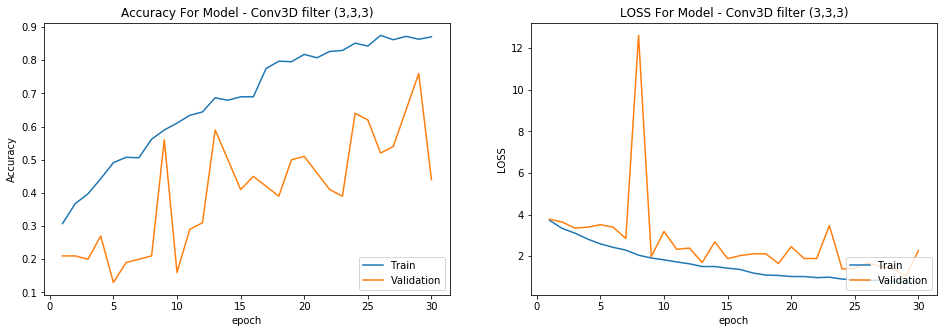

In [23]:
#Plotting the Accuracy for each Epoch
plot_accuracy_loss_per_epoch(model_conv3d_training,'Conv3D filter (3,3,3)')

### 2. Second Model with CNN-RNN architecture
- Resetting all the global variables for Second type of architecture (CNN-RNN ):
- As the transfer learning from imagenet accepts the input in (224,224)

In [24]:
image_x = 160
image_y = 160
frame_per_video = 30
batch_size = 20
num_epochs = 40 

In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU,LSTM,Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2

#write your model here
cnn = Sequential()
# Conv3D
# BatchNorm(before or after Activation)
# Activation
# BatchNorm
# MaxPooling3D
cnn.add(Conv2D(16, (3, 3), padding='same', input_shape=(image_x, image_y, no_of_channels)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) #can use elu as well
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(image_x, image_y, no_of_channels)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) #can use elu as well
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(64, (3, 3), padding='same', input_shape=(image_x, image_y, no_of_channels)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) #can use elu as well
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(128, (3, 3), padding='same', input_shape=(image_x, image_y, no_of_channels)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) #can use elu as well
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(264, (3, 3), padding='same', input_shape=(image_x, image_y, no_of_channels)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) #can use elu as well
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

#model.add(LSTM(100,return_sequences=True))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(64, activation='relu'))
model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frame_per_video, image_x, image_y, no_of_channels)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(.2)) #added
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 64)            2110152   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 2,176,845
Trainable params: 2,175,837
Non-trainable params: 1,008
_________________________________________________________________


In [26]:
model_cnn_rnn = compile_and_print_summary(model,'Adadelta',learning_rate=0.01)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 64)            2110152   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 2,176,845
Trainable params: 2,175,837
Non-trainable params: 1,008
_________________________________________________________________
None


In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_CNN_RNN_BiLSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_CNN_RNN_BiLSTM-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#LR = '0.01' # write the REducelronplateau code here
#monitor 	quantity to be monitored.
#factor 	factor by which the learning rate will be reduced. new_lr = lr * factor
#patience 	number of epochs with no improvement after which learning rate will be reduced. 
#cooldown 	number of epochs to wait before resuming normal operation after lr has been reduced.
early_stopping = EarlyStopping(patience=10)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR,early_stopping]

In [29]:
#Load the model from the existing saved model if exist:
from keras.models import load_model

model_file = './model_CNN_RNN_BiLSTM_0.h5'
import os.path
if os.path.isfile(model_file):
    print('Loading the weights from h5 file ', model_file)

    model = load_model(model_file)

In [30]:
model_cnn_rnn_training = model_cnn_rnn.fit_generator(train_generator,
                                                     steps_per_epoch=steps_per_epoch, 
                                                     epochs=num_epochs, verbose=1,
                                                     callbacks=callbacks_list, 
                                                     validation_data=val_generator,
                                                     validation_steps=validation_steps,
                                                     class_weight=None, workers=1,
                                                     initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - 92s 3s/step - loss: 1.6302 - categorical_accuracy: 0.2103 - val_loss: 1.5380 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 1.53802, saving model to model_CNN_RNN_BiLSTM_2020-06-2816_04_42.727803/model_CNN_RNN_BiLSTM-00001-1.63018-0.21029-1.53802-0.27000.h5
Epoch 2/40
34/34 [==============================] - 77s 2s/step - loss: 1.4833 - categorical_accuracy: 0.3015 - val_loss: 1.6953 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss did not improve from 1.53802
Epoch 3/40
34/34 [==============================] - 78s 2s/step - loss: 1.3657 - categorical_accuracy: 0.3368 - val_loss: 1.8541 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 1.53802
Epoch 4/40
34/34 [==============================] - 78s 2s/step - loss: 1.3849 - categorical_accuracy: 0.3559 - val_loss

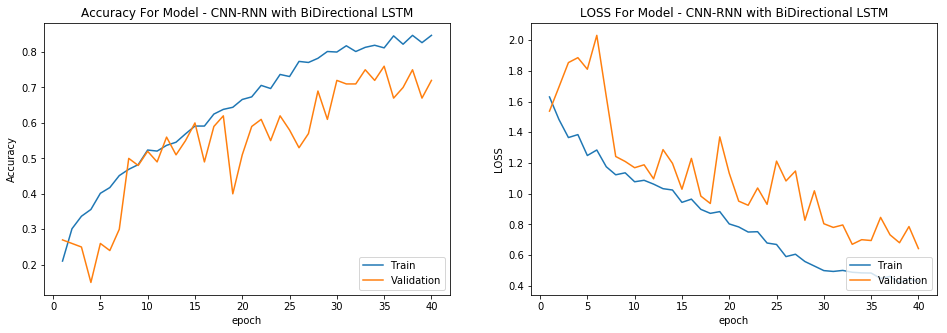

In [31]:
#Plotting the Accuracy for each Epoch
plot_accuracy_loss_per_epoch(model_cnn_rnn_training,'CNN-RNN with BiDirectional LSTM')

### 3. Third Model with CNN-RNN architecture(Transfer learning from imagenet)
- Resetting all the global variables for Second type of architecture (CNN-RNN ):
- As the transfer learning from imagenet accepts the input in (224,224)

In [32]:
#Re-Setting few global variables that are required for further code:
image_x = 224
image_y = 224
batch_size = 4
frame_per_video = 20
dense_dropout_rate = 0.35

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation , Bidirectional, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.regularizers import l2
#from keras.layers.recurrent import LSTM
from keras.applications import mobilenet

#Pre-Trained model for transfer learning :
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(frame_per_video, image_x, image_y, no_of_channels)))

#Disabling the learning of training parameters for pre-Trained model
#for layer in model.layers:
#    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

#model.add(GRU(64))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(dense_dropout_rate))

model.add(Dense(64,activation='relu'))
model.add(Dropout(dense_dropout_rate))

model.add(Dense(num_classes, activation='softmax'))


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step


In [34]:
model_transfer_learning = compile_and_print_summary(model,'SGD',learning_rate=0.002)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 20, 7, 7, 1024)    3228864   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 7, 7, 1024)    4096      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 3, 3, 1024)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 9216)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               4751872   
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
__________

In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_transfer_learning_BiLSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_transfer_learning_BiLSTM-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = '0.01' # write the REducelronplateau code here
#monitor 	quantity to be monitored.
#factor 	factor by which the learning rate will be reduced. new_lr = lr * factor
#patience 	number of epochs with no improvement after which learning rate will be reduced. 
#cooldown 	number of epochs to wait before resuming normal operation after lr has been reduced.
early_stopping = EarlyStopping(patience=10)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR,early_stopping]

In [37]:
#Load the model from the existing saved model if exist:
from keras.models import load_model

model_file = './2-1-model_transfer_learning_BiLSTM-00015-0.06092-0.98193-0.18759-0.92308.h5'
import os.path
if os.path.isfile(model_file):
    print('Loading the weights from h5 file ', model_file)

    model_transfer_learning = load_model(model_file)

In [ ]:
model_transfer_learningtraining = model_transfer_learning.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list,  validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 4
Source path =  ./Project_data/train ; batch size = 4
Epoch 1/40
34/34 [==============================] - 50s 1s/step - loss: 1.6778 - categorical_accuracy: 0.2647 - val_loss: 1.5693 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to model_transfer_learning_BiLSTM_2020-06-2816_04_42.727803/model_transfer_learning_BiLSTM-00001-1.67778-0.26471-1.56933-0.15000.h5
Epoch 2/40
34/34 [==============================] - 38s 1s/step - loss: 1.6047 - categorical_accuracy: 0.2721 - val_loss: 1.4751 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_transfer_learning_BiLSTM_2020-06-2816_04_42.727803/model_transfer_learning_BiLSTM-00002-1.60466-0.27206-1.47506-0.40000.h5
Epoch 3/40
34/34 [==============================] - 38s 1s/step - loss: 1.5166 - categorical_accuracy: 0.3456 - val_loss: 1.4784 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_transfer_learning_BiLSTM_2020-06-2816_04_42.727803

In [ ]:
plot_accuracy_loss_per_epoch(model_transfer_learningtraining,'Transfer learning with GRU as RNN layer')

## Mode Comparision Summary:

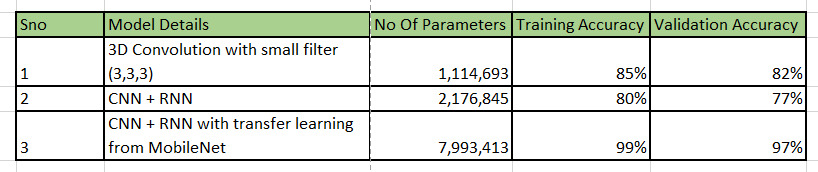

## Model Evaluation :

In [ ]:
def return_formated_output(test_labels,predict_labels):    
    import pandas as pd
    predict_labels = np.argmax(predict_labels,axis=1)
    test_labels = np.argmax(test_labels,axis=1)
    print(predict_labels)
    print(test_labels)
    #print([label_to_name[i] for i in predict_labels])
    data = {'Actual Label':[label_to_name[i] for i in test_labels],'Predicted Label':[label_to_name[i] for i in predict_labels]}
    df = pd.DataFrame(data) 
    return df

In [ ]:
#Loading the best model that is generated so far:
from keras.models import load_model

model_file = './model-transfer_learning-00014-0.01048-0.99550-0.00028-0.98039.h5'

import os.path
if os.path.isfile(model_file):
    print('Loading the model from h5 file ', model_file)
    final_model = load_model(model_file)

#Lable to name mapping:
label_to_name = {0:'Left Swipe',1:'Right Swipe',2:'Stop',3:'Thumbs Down',4:'Thumbs Up'}
#Picking small set of random inputs from validation set and predicting the output from generated model:
image_x = 224
image_y = 224
test_data,test_labels = next(generator(val_path, val_doc, 8))
predict_labels = final_model.predict(test_data)
model_output_df = return_formated_output(test_labels,predict_labels)
model_output_df